In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import pandas as pd
from gplearn.tests.test_genetic import *
from gplearn._program import _Program
from gplearn.genetic import _all_func_dictionary, _fitness_map

In [3]:
df = pd.read_parquet('/home/pennymax/proj/MFM/CrossSection/v1_basic/results/basic_2023-11-22_22:15:18/fct_man_ta_proc.parquet')

In [28]:
def convert_expression_to_gp_program(expression: str, function_set: dict, feature_names: list) -> _Program:
    ## convert expression to list function obj and feature index
    tokens = re.findall(r'[\w.]+|\(|\)|,', expression)
    tokens = [t for t in tokens if t not in ['(', ')', ',']]
    # print(tokens)
    program = []
    for token in tokens:
        if token in function_set:
            program.append(function_set[token])
        elif token in feature_names:
            program.append(feature_names.index(token))
        elif token.isdigit():
            program.append(int(token))
        elif token.replace('.', '', 1).isdigit():
            program.append(float(token))
        else:
            print(f'!! unknown token found! {token}')
            return None
    # print(program)

    ## get arity dict
    arities = {}
    for function in function_set.values():
        arity = function.arity
        arities[arity] = arities.get(arity, [])
        arities[arity].append(function)

    ## construct _Program obj
    params = {
            'function_set': function_set,
            'arities': arities,
            'n_features': len(feature_names),
            'feature_names': feature_names,
            'init_depth': (2, 6),
            ## must inputs
            'init_method': 'half and half',
            'const_range': (-1.0, 1.0),
            'metric': 'mean absolute error',
            'p_point_replace': 0.05,
            'parsimony_coefficient': 0.1,
            'random_state': check_random_state(415),
            }
    gp = _Program(program=program, **params)
    return gp


exp = 'sub(mul(BCKRET1_MOM_5, SPOTVOLUME_TSIs_13_25_13), premIdx_close)'
exp = 'sub(SPOT_COPC_11_14_10, ts_correlation_20(SPOTTAKERBUYQUOVOL_PPOh_12_26_9, TRDCNT_TSI_13_25_13))'
exp = 'inv(rank(TZS60_spot_Close))'
exp = 'ts_mean_20(inv(inv(TZS60_spot_Close)))'
exp = 'min(NETBUYQUO1_FWMA_10, ts_min_10(TZS60_SPOT_HLC3))'
exp = 'add(premIdx_close, max(TZS60_VOLUME_PPO_12_26_9, PREMCLOSE_MACDs_12_26_9))'

print(f'ori expression: {exp}')
feature_names = df.columns.to_list()
gp = convert_expression_to_gp_program(exp, _all_func_dictionary, feature_names)
print(f'_Program print: {gp}')

ori expression: add(premIdx_close, max(TZS60_VOLUME_PPO_12_26_9, PREMCLOSE_MACDs_12_26_9))
_Program print: add(premIdx_close, max(TZS60_VOLUME_PPO_12_26_9, PREMCLOSE_MACDs_12_26_9))


In [40]:
def _get_X_y(df):
    dfX = df.drop(columns=[col for col in df.columns if col.startswith('fwdret')])
    feature_names = list(dfX.columns)
    dfX = dfX.unstack()
    X = dfX.values.reshape(len(dfX), len(feature_names), -1)

    y = df[['fwdret1']].unstack().to_numpy()
    return X, y, feature_names

X, y, feature_names = _get_X_y(df)
y_pred = gp.execute_3D(X)
metric_func = _fitness_map['quantile35_longshort_fee_fast']
metric_val = metric_func(y, y_pred, np.ones(X.shape[0]))
print(metric_val)
display(y_pred)

1.587969256457208


array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       ...,
       [            nan, -5.37248379e-01,  7.18089985e-01, ...,
         1.20309105e+00,  1.04466502e+00, -1.85869427e+00],
       [            nan, -2.43286648e+00, -4.56277294e-01, ...,
        -8.46932117e-04,  6.45284825e-01, -1.08513454e+00],
       [            nan, -3.72754171e-01,  1.22700826e-01, ...,
         3.27948710e+00,  1.77023649e+00, -6.63427043e-01]])

0.25
1.0     2.589502
2.0     1.662374
3.0     1.294676
4.0     1.259953
5.0     1.043971
6.0     0.628751
7.0     0.923621
8.0     0.677423
9.0     0.786518
10.0    0.901202
11.0    0.575835
12.0    0.427843
13.0    0.667564
14.0    0.407907
15.0    0.556015
16.0    0.559469
17.0    0.098313
18.0    0.043004
19.0    0.349466
20.0   -0.905030
dtype: float64


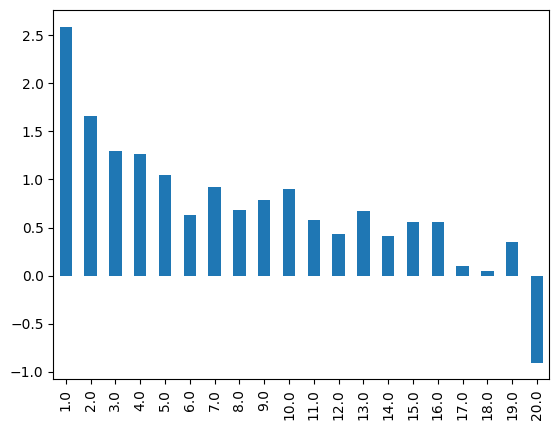

In [41]:
from gplearn.extra_fitness import *

res, qtl = compute_quantile_rets_fast(y, y_pred, np.ones(X.shape[0]), 20)
res.plot.bar()
print(measure_monotonicity(res))
print(res)

0.25
1     2.589502
2     1.662374
3     1.294676
4     1.259953
5     1.043971
6     0.628751
7     0.923621
8     0.677423
9     0.786518
10    0.901202
11    0.575835
12    0.427843
13    0.667564
14    0.407907
15    0.554145
16    0.561416
17    0.098313
18    0.043004
19    0.349466
20   -0.905030
dtype: float64


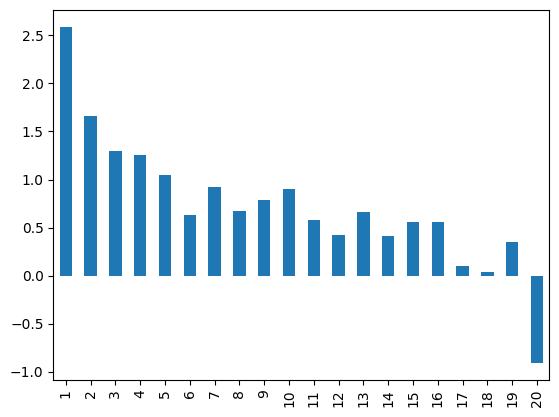

In [36]:
res, qtl = compute_quantile_rets(y, y_pred, np.ones(X.shape[0]), 20)
res.plot.bar()
print(measure_monotonicity(res))
print(res)

In [20]:
from gplearn.extra_fitness import *
quantiles =35

res1, factor_quantiles1 = compute_quantile_rets(y, y_pred, np.ones(X.shape[0]), quantiles)
display(factor_quantiles1.dropna(axis=0, how='all'))
long_turnover1 = turnover_rate(factor_quantiles1[factor_quantiles1 == quantiles])
print(long_turnover1)

res2, factor_quantiles2 = compute_quantile_rets_fast(y, y_pred, np.ones(X.shape[0]), quantiles)
display(factor_quantiles2.dropna(axis=0, how='all'))
long_turnover2 = turnover_rate(factor_quantiles2[factor_quantiles2 == quantiles])
print(long_turnover2)

,0,1,2,3,4,5,6,7,8,9,...,227,228,229,230,231,232,233,234,235,236
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,NaN,18,18,18,18,19,14,30,26,6,...,16,35,12,NaN,12,11,29,15,10,14
4196,NaN,22,22,22,23,23,13,30,21,7,...,17,35,14,NaN,19,11,26,20,7,17
4197,NaN,23,23,24,24,NaN,16,29,23,6,...,18,35,18,NaN,18,14,22,21,9,18
4198,NaN,24,24,24,24,NaN,18,31,21,6,...,19,35,12,NaN,21,16,23,21,9,20


0.28677037616666096


,0,1,2,3,4,5,6,7,8,9,...,227,228,229,230,231,232,233,234,235,236
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,NaN,18.0,18.0,18.0,18.0,19.0,14.0,30.0,26.0,6.0,...,16.0,35.0,12.0,NaN,12.0,11.0,29.0,15.0,10.0,14.0
4196,NaN,22.0,22.0,22.0,23.0,23.0,13.0,30.0,21.0,7.0,...,17.0,35.0,14.0,NaN,19.0,11.0,26.0,20.0,7.0,17.0
4197,NaN,23.0,23.0,24.0,24.0,NaN,16.0,29.0,23.0,6.0,...,18.0,35.0,18.0,NaN,18.0,14.0,22.0,21.0,9.0,18.0
4198,NaN,24.0,24.0,24.0,24.0,NaN,18.0,31.0,21.0,6.0,...,19.0,35.0,12.0,NaN,21.0,16.0,23.0,21.0,9.0,20.0


0.28677037616666096


In [5]:
dffct = pd.read_csv('/home/pennymax/proj/MFM/CrossSection/v1_basic/results/basic_2023-11-22_22:15:18/best_programs.csv')
ori_exps = dffct.Expression.to_list()
gp_exps = []
for exp in ori_exps:
    gp = convert_expression_to_gp_program(exp, _all_func_dictionary, feature_names)
    gp_exps.append(gp.__str__())
dfcomp = pd.DataFrame({
    'ori_exps': ori_exps,
    'gp_exps': gp_exps
})
dfcomp['is_same'] = dfcomp.ori_exps == dfcomp.gp_exps
display(dfcomp)
dfcomp[dfcomp.is_same==True].shape[0]

,ori_exps,gp_exps,is_same
0,"ts_max_5(sub(max(SPOTTAKERBUYVOL_RSX_14, PREMC...","ts_max_5(sub(max(SPOTTAKERBUYVOL_RSX_14, PREMC...",True
1,"ts_max_5(ts_max_5(sub(FUND_MACD_12_26_9, TZS60...","ts_max_5(ts_max_5(sub(FUND_MACD_12_26_9, TZS60...",True
2,ts_min_20(TZS60_HMA_10),ts_min_20(TZS60_HMA_10),True
3,"max(sub(FUND_MACD_12_26_9, TZS60_HMA_10), PREM...","max(sub(FUND_MACD_12_26_9, TZS60_HMA_10), PREM...",True
4,ts_min_3(ts_min_20(TZS60_HMA_10)),ts_min_3(ts_min_20(TZS60_HMA_10)),True
5,delay_1(ts_min_20(TZS60_HMA_10)),delay_1(ts_min_20(TZS60_HMA_10)),True
6,PREMCLOSE_RSI_14,PREMCLOSE_RSI_14,True
7,"ts_max_5(sub(FUND_MACD_12_26_9, TZS60_HMA_10))","ts_max_5(sub(FUND_MACD_12_26_9, TZS60_HMA_10))",True
8,SMIs_5_20_5,SMIs_5_20_5,True
9,"sub(FUND_MACD_12_26_9, TZS60_HMA_10)","sub(FUND_MACD_12_26_9, TZS60_HMA_10)",True


16